In [1]:
# # Download + Unpacking test-clean of librispeech
# import shutil
# from speechbrain.utils.data_utils import download_file

# MINILIBRI_TEST_URL = "https://www.openslr.org/resources/12/test-clean.tar.gz"
# download_file(MINILIBRI_TEST_URL, 'test-clean.tar.gz')
# shutil.unpack_archive( 'test-clean.tar.gz', '.')

In [7]:
import torch
import torchaudio
import torch.nn.functional as F
from torchaudio.utils import download_asset
# from common import data_uncertainty
from IPython.display import Audio
import speechbrain as sb
from speechbrain.pretrained import EncoderDecoderASR

class MyASR(EncoderDecoderASR):
    """A ready-to-use Encoder-Decoder ASR model

    The class can be used either to run only the encoder (encode()) to extract
    features or to run the entire encoder-decoder model
    (transcribe()) to transcribe speech. The given YAML must contains the fields
    specified in the *_NEEDED[] lists.

    Example
    -------
    >>> from speechbrain.pretrained import EncoderDecoderASR
    >>> tmpdir = getfixture("tmpdir")
    >>> asr_model = EncoderDecoderASR.from_hparams(
    ...     source="speechbrain/asr-crdnn-rnnlm-librispeech",
    ...     savedir=tmpdir,
    ... )
    >>> asr_model.transcribe_file("tests/samples/single-mic/example2.flac")
    "MY FATHER HAS REVEALED THE CULPRIT'S NAME"
    """

    HPARAMS_NEEDED = ["tokenizer"]
    MODULES_NEEDED = ["encoder", "decoder"]
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tokenizer = self.hparams.tokenizer
        
    def transcribe_file(self, path):
        """Transcribes the given audiofile into a sequence of words.

        Arguments
        ---------
        path : str
            Path to audio file which to transcribe.

        Returns
        -------
        str
            The audiofile transcription produced by this ASR system.
        """
        waveform = self.load_audio(path)
        # Fake a batch:
        batch = waveform.unsqueeze(0)
        rel_length = torch.tensor([1.0])
        predicted_words, predicted_tokens, predicted_log_probs = self.transcribe_batch(
            batch, rel_length
        )
        return predicted_words[0]
    
    def transcribe_batch(self, wavs, wav_lens):
        """Transcribes the input audio into a sequence of words

        The waveforms should already be in the model's desired format.
        You can call:
        ``normalized = EncoderDecoderASR.normalizer(signal, sample_rate)``
        to get a correctly converted signal in most cases.

        Arguments
        ---------
        wavs : torch.tensor
            Batch of waveforms [batch, time, channels] or [batch, time]
            depending on the model.
        wav_lens : torch.tensor
            Lengths of the waveforms relative to the longest one in the
            batch, tensor of shape [batch]. The longest one should have
            relative length 1.0 and others len(waveform) / max_length.
            Used for ignoring padding.

        Returns
        -------
        list
            Each waveform in the batch transcribed.
        tensor
            Each predicted token id.
        """
        with torch.no_grad():
            wav_lens = wav_lens.to(self.device)
            encoder_out = self.encode_batch(wavs, wav_lens)
            predicted_tokens, scores, predicted_log_probs = self.mods.decoder(encoder_out, wav_lens)
            predicted_words = [
                self.tokenizer.decode_ids(token_seq)
                for token_seq in predicted_tokens
            ]
        return predicted_words, predicted_tokens, predicted_log_probs

In [63]:
audio_1 = "LibriSpeech/test-clean/1089/134686/1089-134686-0030.flac"
model = "asr-crdnn-rnnlm-librispeech" 
# model = "asr-transformer-transformerlm-librispeech"
# model = "asr-transformer-transformerlm-librispeech"

# Uncomment for using another pre-trained model
asr_model = MyASR.from_hparams(
    source=f"speechbrain/{model}", 
    savedir=f"pretrained_models/{model}", 
    # run_opts={"device":"cuda"}, # inference on GPU
    hparams_file="hyperparams.yaml",
)
asr_model.transcribe_file(audio_1)

'BEWARE OF MAKING THAT MISTAKE'

In [64]:
asr_model

MyASR(
  (mods): ModuleDict(
    (normalizer): InputNormalization()
    (encoder): LengthsCapableSequential(
      (compute_features): Fbank(
        (compute_STFT): STFT()
        (compute_fbanks): Filterbank()
        (compute_deltas): Deltas()
        (context_window): ContextWindow()
      )
      (normalize): InputNormalization()
      (model): CRDNN(
        (CNN): Sequential(
          (block_0): CNN_Block(
            (conv_1): Conv2d(
              (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
            )
            (norm_1): LayerNorm(
              (norm): LayerNorm((40, 128), eps=1e-05, elementwise_affine=True)
            )
            (act_1): LeakyReLU(negative_slope=0.01)
            (conv_2): Conv2d(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
            )
            (norm_2): LayerNorm(
              (norm): LayerNorm((40, 128), eps=1e-05, elementwise_affine=True)
            )
            (act_2): LeakyReLU(negative_slop

In [34]:
# asr_model (EncoderDecoderASR)
# mods: ModuleDict(InputNormalization, Encoder, Decoder, LM)
    # Encoder: LengthsCapableSequential
    # Decoder: S2SRNNBeamSearchTransformerLM
    # LM: TransformerLM
from speechbrain.nnet.containers import LengthsCapableSequential
from speechbrain.decoders import S2SRNNBeamSearchLM, S2SRNNBeamSearchTransformerLM
from speechbrain.lobes.models.transformer.TransformerLM import TransformerLM

return_log_probs = True
emb = torch.nn.Embedding(5, 3)
dec = sb.nnet.RNN.AttentionalRNNDecoder(
    "gru", "content", 3, 3, 1, enc_dim=7, input_size=3
)
lin = sb.nnet.linear.Linear(n_neurons=5, input_size=3)
lm = TransformerLM(5, 512, 8, 1, 0, 1024, activation=torch.nn.GELU)
searcher = S2SRNNBeamSearchTransformerLM(
    embedding=emb,
    decoder=dec,
    linear=lin,
    language_model=lm,
    bos_index=4,
    eos_index=4,
    blank_index=4,
    min_decode_ratio=0,
    max_decode_ratio=1,
    beam_size=2,
    lm_weight=0.5,
    return_log_probs=return_log_probs,
)
enc = torch.rand([2, 6, 7]) # B X T X D
wav_len = torch.rand([2]) # B
outputs = searcher(enc, wav_len)
if return_log_probs:
    predictions, topk_scores, log_probs = outputs
    print("log-probs: ", log_probs)
else:
    predictions, topk_scores = outputs
print("predictions: ", predictions)
print("topk_scores: ", topk_scores)

log-probs:  [tensor([-1.8187]), tensor([-1.8035])]
predictions:  [[], []]
topk_scores:  tensor([[-2.0114],
        [-1.9961]], grad_fn=<TopkBackward0>)


In [42]:
audio_1 = "LibriSpeech/test-clean/1089/134686/1089-134686-0029.flac"
waveform = asr_model.load_audio(audio_1)
# Fake a batch
batch = waveform.unsqueeze(0)
print('wave tensor: ', batch.shape)
rel_length = torch.tensor([1.0])
# predicted_words, predicted_tokens = asr_model.transcribe_batch(batch, rel_length)
with torch.no_grad():
    wav_lens = rel_length
    encoder_out = asr_model.encode_batch(batch, wav_lens) # B X T X D
    print(encoder_out.shape)
    predicted_tokens, scores, log_probs = asr_model.mods.decoder(encoder_out, wav_lens)
    print([len(tokens) for tokens in predicted_tokens])
    print("scores: ", scores.shape)
    print("log_probs: ", [log_prob.shape for log_prob in log_probs])
    predicted_words = [
        asr_model.tokenizer.decode_ids(token_seq)
        for token_seq in predicted_tokens
    ]
    print(predicted_words)

wave tensor:  torch.Size([1, 74720])
torch.Size([1, 117, 512])
[21]
scores:  torch.Size([1, 1])
log_probs:  [torch.Size([22])]
['ON FRIDAY CONFESSION WILL BE HEARD ALL THE AFTERNOON AFTER BEADS']


In [16]:
preds1 = 'BEWARE OF MAKING THAT MISTAKE'
preds2 = 'GIVE NOT SO EARNEST A MIND TO THESE MUMMERIES CHILD'

In [101]:
asr_model.tokenizer.decode_ids([224, 336, 11, 53, 90, 32, 66, 49])

'MISTAKEL ANEN MY SHE'

In [8]:
import re
f = open("LibriSpeech-asr-crdnn-rnnlm-librispeech-energy.log", "r")
unit = "mW"
inss, avgs = [], []
for line in f:
    r = re.compile('VDD_GPU_SOC (.+?)([ \.]|$)')
    patterns = re.findall(r, line)
    if not patterns:
        continue
    GPU_pair = patterns[0][0]
    ins, avg = GPU_pair.split('/')
    ins = int(ins.rstrip(unit))
    inss.append(ins)
    avg = int(avg.rstrip(unit))
    avgs.append(avg)

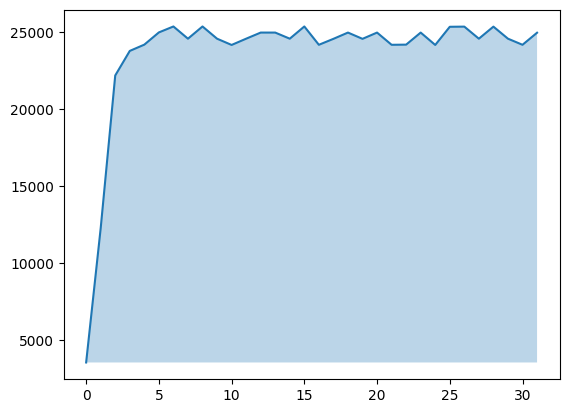

In [83]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


xx = np.arange(len(inss))
yy = np.array(inss)
plt.plot(xx, yy)
plt.fill_between(xx, yy, y2 = min(yy), alpha=0.3,)

plt.show()

### Add noise

LibriSpeech/test-clean/1089/134686/1089-134686-0030.flac
torch.Size([1, 43440])


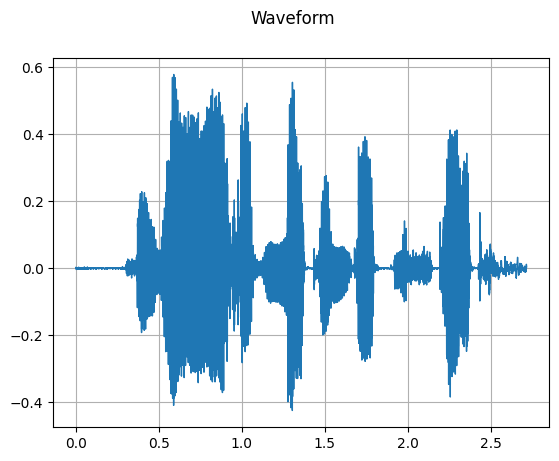

In [34]:
SAMPLE_WAV = "LibriSpeech/test-clean/1089/134686/1089-134686-0030.flac"
# SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
print(SAMPLE_WAV)
waveform = asr_model.load_audio(SAMPLE_WAV).unsqueeze(0)

print(waveform.shape)
plot_waveform(waveform, 16000)
Audio(waveform, rate=16000)

torch.Size([1, 80000])


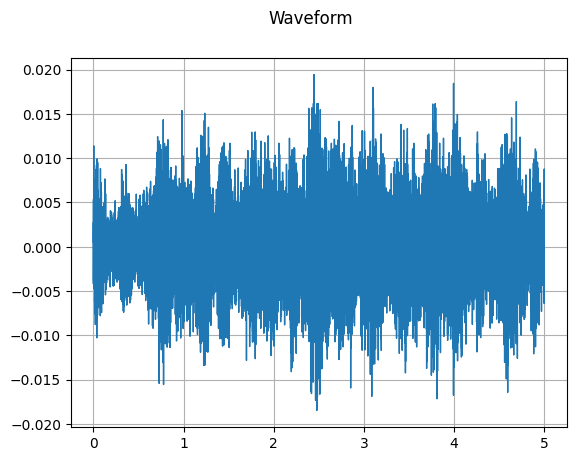

In [52]:
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")
# noise, noise_sample_rate = torchaudio.load(SAMPLE_NOISE)
noise = asr_model.load_audio(SAMPLE_NOISE).unsqueeze(0)
print(noise.shape)
plot_waveform(noise, 16000)
Audio(noise, rate=16000)

torch.Size([1, 43440]) torch.Size([1, 43440])
torch.Size([3, 43440])


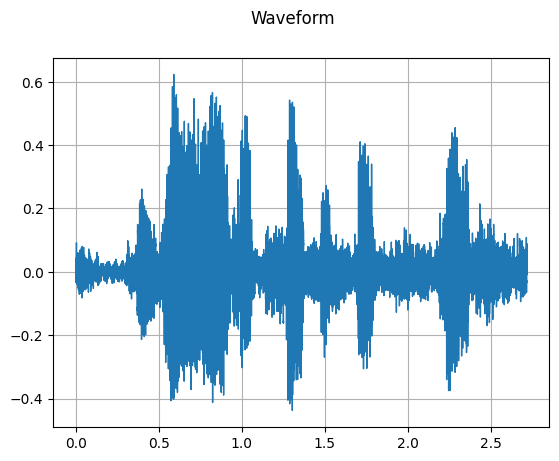

In [61]:
from math import ceil
# Handle noise
if noise.shape[1] < waveform.shape[1]:
    K = ceil(waveform.shape[1] / noise.shape[1])
    noi = noise.repeat(1, K)[:, :waveform.shape[1]]
else:
    noi = noise[:, :waveform.shape[1]]

print(waveform.shape, noi.shape)
snr_dbs = torch.tensor([20, 10, 3])
noisy_speech = add_noise(waveform, noi, snr_dbs)
print(noisy_speech.shape)
plot_waveform(noisy_speech.mean(dim=0).unsqueeze(0), 16000)
Audio(noisy_speech.mean(dim=0).unsqueeze(0), rate=16000)
# noisy_speech = waveform + noi
# print(noisy_speech)
# plot_waveform(noisy_speech, 16000)
# Audio(noisy_speech, rate=16000)

In [16]:
import torch
from typing import Optional

def add_noise(
    waveform: torch.Tensor, noise: torch.Tensor, snr: torch.Tensor, lengths: Optional[torch.Tensor] = None
) -> torch.Tensor:
    if not (waveform.ndim - 1 == noise.ndim - 1 == snr.ndim and (lengths is None or lengths.ndim == snr.ndim)):
        raise ValueError("Input leading dimensions don't match.")

    L = waveform.size(-1)

    if L != noise.size(-1):
        raise ValueError(f"Length dimensions of waveform and noise don't match (got {L} and {noise.size(-1)}).")

    # compute scale
    if lengths is not None:
        mask = torch.arange(0, L, device=lengths.device).expand(waveform.shape) < lengths.unsqueeze(
            -1
        )  # (*, L) < (*, 1) = (*, L)
        masked_waveform = waveform * mask
        masked_noise = noise * mask
    else:
        masked_waveform = waveform
        masked_noise = noise

    energy_signal = torch.linalg.vector_norm(masked_waveform, ord=2, dim=-1) ** 2  # (*,)
    energy_noise = torch.linalg.vector_norm(masked_noise, ord=2, dim=-1) ** 2  # (*,)
    original_snr_db = 10 * (torch.log10(energy_signal) - torch.log10(energy_noise))
    scale = 10 ** ((original_snr_db - snr) / 20.0)  # (*,)

    # scale noise
    scaled_noise = scale.unsqueeze(-1) * noise  # (*, 1) * (*, L) = (*, L)

    return waveform + scaled_noise  # (*, L)

In [59]:
# SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")
# noise, noise_sample_rate = torchaudio.load(SAMPLE_NOISE)

SAMPLE_WAV = "LibriSpeech/test-clean/1089/134686/1089-134686-0030.flac"
# SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
print(SAMPLE_WAV)
waveform = asr_model.load_audio(SAMPLE_WAV)
# Fake a batch
batch = waveform.unsqueeze(0)
print('wave tensor: ', batch.shape)
# Add noise
noise = torch.tensor(np.random.normal(0, 0.5, 100000).reshape(1, -1))
noise = noise[:, :waveform.shape[0]]
snr_dbs = torch.tensor([20, 10, 3])
noisy_speech = add_noise(batch, noise, snr_dbs)
rel_length = torch.tensor([1.0])

predicted_words, predicted_tokens = asr_model.transcribe_batch(batch, rel_length)
print(predicted_words)
predicted_words, predicted_tokens = asr_model.transcribe_batch(noisy_speech[1:2], rel_length)
print(predicted_words)
# with torch.no_grad():
#     wav_lens = rel_length
#     encoder_out = asr_model.encode_batch(batch, wav_lens) # B X T X D
#     print(encoder_out.shape)
#     predicted_tokens, scores = asr_model.mods.decoder(encoder_out, wav_lens)
#     print(predicted_tokens)
#     predicted_words = [
#         asr_model.tokenizer.decode_ids(token_seq)
#         for token_seq in predicted_tokens
#     ]
#     print(predicted_words)

LibriSpeech/test-clean/1089/134686/1089-134686-0030.flac
wave tensor:  torch.Size([1, 43440])
['BEWARE OF MAKING THAT MISTAKE']
['BEWARE OF MAKING THAT MISTAKE']


In [43]:
from IPython.display import Audio

# noisy_speech.shape
Audio(noise, rate=noise_sample_rate)

In [14]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

Audio(waveform, rate=sample_rate)

In [61]:
Audio(noisy_speech, rate=16000)

In [133]:
batch.shape

torch.Size([1, 39680])

In [160]:
waveform.shape

torch.Size([1, 43440])

In [54]:
noise.shape

(1, 80000)

In [169]:
noise_sample_rate

8000

In [177]:
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

In [25]:
# import os
# from pathlib import Path
# SAMPLE_RATE = 44100
# BASE_DIR = Path(os.path.abspath(os.path.dirname(os.path.dirname(__file__))))
# SCRIPTS_DIR = BASE_DIR / "scripts"
# TEST_FIXTURES_DIR = BASE_DIR / "test_fixtures"

from torch_audiomentations import Compose, Gain, PolarityInversion, AddBackgroundNoise
from torch_audiomentations.utils import TEST_FIXTURES_DIR

# Initialize augmentation callable
apply_augmentation = Compose(
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.5,
        ),
        PolarityInversion(p=0.5),
        AddBackgroundNoise(
            background_paths=TEST_FIXTURES_DIR / "bg", 
            p=0.5,
        )
    ]
)

perturbed_audio_samples = apply_augmentation(batch.unsqueeze(0), sample_rate=16000)

# modes = ["per_batch", "per_example", "per_channel"]
# for mode in modes:
#     transform = {
#         "get_instance": lambda: AddBackgroundNoise(
#             background_paths=TEST_FIXTURES_DIR / "bg", mode=mode, p=1.0
#         ),
#         "num_runs": 5,
#     }
#     perturbed_audio_samples = transform(batch.unsqueeze(0), sample_rate=SAMPLE_RATE)
    

# transform = AddBackgroundNoise(
#     os.path.join(tempfile.gettempdir(), str(uuid.uuid4())),
#     min_snr_in_db=4,
#     max_snr_in_db=6,
#     p=1.0,
#     sample_rate=16000,
#     output_type="dict",
# )

ModuleNotFoundError: No module named 'torch_audiomentations.test'

In [180]:
batch.shape

torch.Size([1, 43440])

In [19]:
perturbed_audio_samples

tensor([[[-0.0003, -0.0003, -0.0003,  ..., -0.0012, -0.0010, -0.0010]]])

In [20]:
Audio(perturbed_audio_samples.squeeze(0), rate=16000)

In [21]:
batch

tensor([[0.0014, 0.0013, 0.0011,  ..., 0.0050, 0.0045, 0.0041]])

In [22]:
Audio(batch, rate=16000)

In [2]:
import matplotlib.pyplot as plt
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [31]:
# self-define gaussian noise
import numpy as np

# Adding noise using a target noise power

# Set a target channel noise power to something very noisy
target_noise_db = 10

# Convert to linear Watt units
target_noise_watts = 10 ** (target_noise_db / 10)

# Generate noise samples
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(x_watts))

# Noise up the original signal (again) and plot
y_volts = x_volts + noise_volts


NameError: name 'x_watts' is not defined

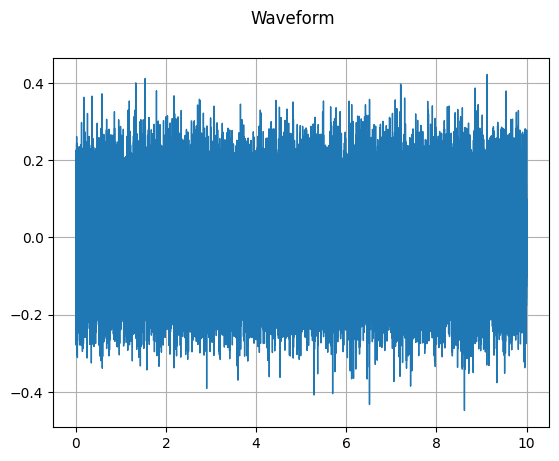

In [52]:

noise = np.random.normal(0, 0.1, 80000).reshape(1, -1)
# plt.plot(noise)
plot_waveform(noise, noise_sample_rate)

In [37]:
noise

array([ 0.06129669,  0.1428289 , -0.22562393,  0.01680306, -0.04210609,
       -0.02950094, -0.07712561,  0.11902833, -0.04600501,  0.10731928,
        0.21174922, -0.09435705, -0.07924281,  0.01593856, -0.04856664,
        0.13948896,  0.26478131,  0.05900534,  0.06046522,  0.01971641,
        0.11931303, -0.04252985,  0.03321272, -0.03958164, -0.13540006,
       -0.21456699, -0.01734341,  0.04371609, -0.09630742,  0.17999746,
       -0.13757868,  0.06736041, -0.030931  ,  0.16678661,  0.1230698 ,
       -0.09394375, -0.07246957, -0.01878624,  0.02712768, -0.05782644,
        0.01123606,  0.10342056,  0.13623773,  0.06150386, -0.04288928,
        0.00432558, -0.07327569,  0.04073574,  0.06598333, -0.20488464,
        0.02906012,  0.06138686,  0.22013756, -0.01776567,  0.12578654,
        0.05677765, -0.05417356,  0.04371969,  0.06922725,  0.19509301,
       -0.07487176, -0.12942463, -0.00934408,  0.01353053, -0.00249957,
        0.12387569, -0.04424402,  0.0797329 ,  0.03469809, -0.11